# PyMC-GP Examples

In [1]:
# 1. 라이브러리 임포트
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# 재현성을 위한 랜덤 시드 설정
np.random.seed(42)

# 2. 비선형 데이터 생성
# ---------------------
# GP가 학습할 샘플 데이터를 만듭니다. sin 함수에 노이즈를 추가합니다.
X = np.linspace(0, 10, 20)[:, None]  # 20개의 훈련 데이터 포인트
true_func = lambda x: np.sin(x) * 1.5
y = true_func(X).ravel() + np.random.normal(0, 0.4, 20) # 실제 함수값에 노이즈 추가


# 3. PyMC를 이용한 GP 모델 정의
# ----------------------------
with pm.Model() as gp_model:
    # --- 커널 하이퍼파라미터에 대한 사전분포(Priors) 설정 ---
    # 길이척도(lengthscale, ℓ): 함수가 얼마나 부드러운지를 제어합니다.
    # Gamma 분포를 사용해 양수 값을 가지도록 합니다.
    lengthscale = pm.Gamma("ℓ", alpha=2, beta=0.5)

    # 출력 스케일(output-scale, η): 함수의 평균적인 변동폭을 제어합니다.
    # HalfCauchy 분포는 양수 값을 가지며, 가끔 큰 값이 나올 수 있도록 유연성을 줍니다.
    eta = pm.HalfCauchy("η", beta=3)

    # --- 커널(공분산 함수) 정의 ---
    # ExpQuad(Squared Exponential) 커널을 사용합니다. 가장 일반적인 선택입니다.
    # 위에서 정의한 하이퍼파라미터(확률 변수)를 커널에 전달합니다.
    cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=lengthscale)

    # --- GP 사전분포(Prior) 정의 ---
    # pm.gp.Latent를 사용해 잠재(Latent) GP를 정의합니다.
    # 이 GP는 우리가 추정하고자 하는 실제 함수 f(x)에 대한 사전 믿음입니다.
    gp = pm.gp.Latent(cov_func=cov_func)

    # 모델이 학습할 데이터 X에 대해 GP 사전분포로부터 함수 f를 생성합니다.
    f = gp.prior("f", X=X)

    # --- 가능도(Likelihood) 정의 ---
    # 관측 노이즈(sigma, σ)에 대한 사전분포를 설정합니다.
    sigma = pm.HalfCauchy("σ", beta=3)

    # 관측된 데이터 y는 잠재 함수 f에 정규분포 노이즈(sigma)가 더해진 결과라고 가정합니다.
    # 이것이 데이터와 GP 모델을 연결하는 핵심 부분입니다.
    y_obs = pm.Normal("y_obs", mu=f, sigma=sigma, observed=y)


# 4. MCMC를 이용한 사후 분포 추론
# -------------------------------
with gp_model:
    # PyMC의 NUTS 샘플러를 사용해 사후 분포에서 2000개의 샘플을 추출합니다.
    # 이 과정에서 f, ℓ, η, σ 등 모든 확률 변수의 사후 분포가 계산됩니다.
    trace = pm.sample(2000, tune=1000, cores=1)


Initializing NUTS using jitter+adapt_diag...
/home/lsw91/Workspace/pymc-gp/.venv/lib/python3.11/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Sequential sampling (2 chains in 1 job)
NUTS: [ℓ, η, f_rotated_, σ]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 69 seconds.
There were 202 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


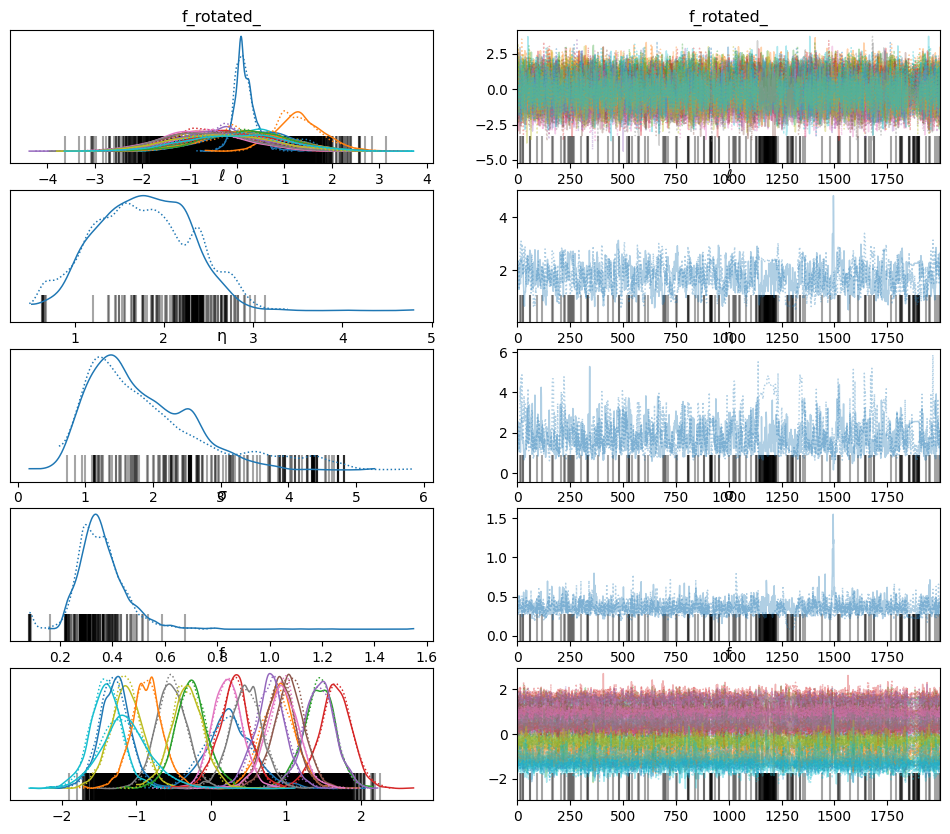

In [2]:
az.plot_trace(trace)
plt.show()

In [3]:
# 5. 새로운 데이터에 대한 예측
# ---------------------------
# 예측을 수행할 새로운 x좌표(X_new)를 촘촘하게 생성합니다.
Xnew = np.linspace(-2, 12, 100)[:, None]

with gp_model:
    # gp.conditional 메서드는 학습된 사후 분포를 기반으로,
    # 새로운 입력 X_new에 대한 함수 값(f_new)의 분포를 계산해줍니다.
    f_pred = gp.conditional("f_pred", Xnew=Xnew)

In [13]:
with gp_model:
    # 위에서 정의한 조건부 분포로부터 예측 샘플을 추출합니다.
    # 이것이 "사후 예측 샘플링" 과정입니다.
    pred_samples = pm.sample_posterior_predictive(trace.posterior.sel(draw=slice(None, None, 20)), var_names=["f_pred"])

Sampling: [f_pred]


Output()

In [44]:
pred_samples

Inference data with groups:
	> posterior_predictive
	> observed_data

In [18]:
pred_samples.posterior_predictive.stack(samples=("chain", "draw"))

<xarray.Dataset> Size: 166kB
Dimensions:       (f_pred_dim_0: 100, samples: 200)
Coordinates:
  * f_pred_dim_0  (f_pred_dim_0) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * samples       (samples) object 2kB MultiIndex
  * chain         (samples) int64 2kB 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1
  * draw          (samples) int64 2kB 0 20 40 60 80 ... 1900 1920 1940 1960 1980
Data variables:
    f_pred        (f_pred_dim_0, samples) float64 160kB -3.183 -2.7 ... -1.732
Attributes:
    created_at:                 2025-10-16T07:17:31.895805+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1

In [27]:
predictions = pred_samples.posterior_predictive.stack(samples=("chain", "draw"))
predictions['f_pred'].isel(samples=0)

<xarray.DataArray 'f_pred' (f_pred_dim_0: 100)> Size: 800B
array([-3.18349096, -3.07866363, -2.94434662, -2.780732  , -2.58862917,
       -2.36948644, -2.12539236, -1.85905823, -1.57377754, -1.27336605,
       -0.96208352, -0.64453828, -0.32557878, -0.01017819,  0.29668914,
        0.59016822,  0.86564261,  1.11884363,  1.3459482 ,  1.54366291,
        1.70928845,  1.84076793,  1.93671424,  1.99641892,  2.01984305,
        2.00759205,  1.96087554,  1.88145703,  1.77159457,  1.6339752 ,
        1.47164703,  1.28795134,  1.08645479,  0.87088621,  0.64507708,
        0.41290691,  0.1782517 , -0.05506015, -0.28329212, -0.50283759,
       -0.7102609 , -0.90233305, -1.07607124, -1.22877773, -1.35807872,
       -1.461965  , -1.53883138, -1.58751343, -1.60732335, -1.59807694,
       -1.56011683, -1.49432515, -1.40212428, -1.2854671 , -1.14681306,
       -0.9890897 , -0.81564167, -0.63016587, -0.43663492, -0.23921209,
       -0.04215787,  0.1502673 ,  0.33390157,  0.50477683,  0.65921069,
        0.79388708,  0.90592938,  0.99295721,  1.05312931,  1.08517188,
        1.08838832,  1.06265634,  1.00840754,  0.9265971 ,  0.81865927,
        0.6864567 ,  0.53222259,  0.35849989,  0.16807784, -0.03606845,
       -0.25083735, -0.47305573, -0.69952864, -0.92708387, -1.15261092,
       -1.37309503, -1.58564646, -1.78752561, -1.97616565, -2.14919263,
       -2.30444444, -2.43998792, -2.5541363 , -2.64546581, -2.71283279,
       -2.75538785, -2.77259085, -2.7642245 , -2.7304037 , -2.67158301])
Coordinates:
  * f_pred_dim_0  (f_pred_dim_0) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    samples       object 8B (np.int64(0), np.int64(0))
    chain         int64 8B 0
    draw          int64 8B 0

In [ ]:
mean_pred['f_pred'].values

array([-0.95499589, -0.9448675 , -0.92529212, -0.89553208, -0.8550262 ,
       -0.80334484, -0.74011847, -0.66500993, -0.57774463, -0.47815972,
       -0.36623509, -0.24211554, -0.10616758,  0.0409029 ,  0.19789505,
        0.3629736 ,  0.5335892 ,  0.7064678 ,  0.87765762,  1.04262979,
        1.19644447,  1.33399724,  1.45034287,  1.54106567,  1.6026425 ,
        1.63273358,  1.63034617,  1.59584359,  1.53080899,  1.43779872,
        1.32002579,  1.18101053,  1.02424347,  0.8529272 ,  0.66987329,
        0.47759617,  0.27856837,  0.07552386, -0.12832598, -0.32924953,
       -0.52312817, -0.70570649, -0.87288684, -1.02101041, -1.14708136,
       -1.24889762, -1.32506859, -1.37493022, -1.39839863, -1.39581545,
       -1.36782864, -1.31533911, -1.23952973, -1.14197265, -1.02477541,
       -0.89068841, -0.7430859 , -0.58576919, -0.42261872, -0.25720219,
       -0.09248271,  0.0692597 ,  0.226265  ,  0.37695327,  0.51953624,
        0.65172202,  0.77062514,  0.87292621,  0.95523384,  1.01

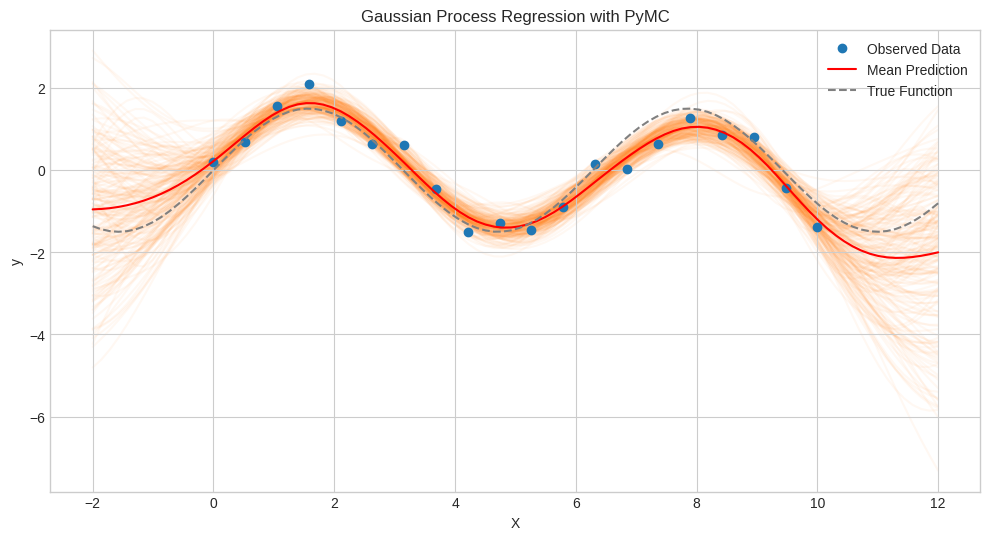

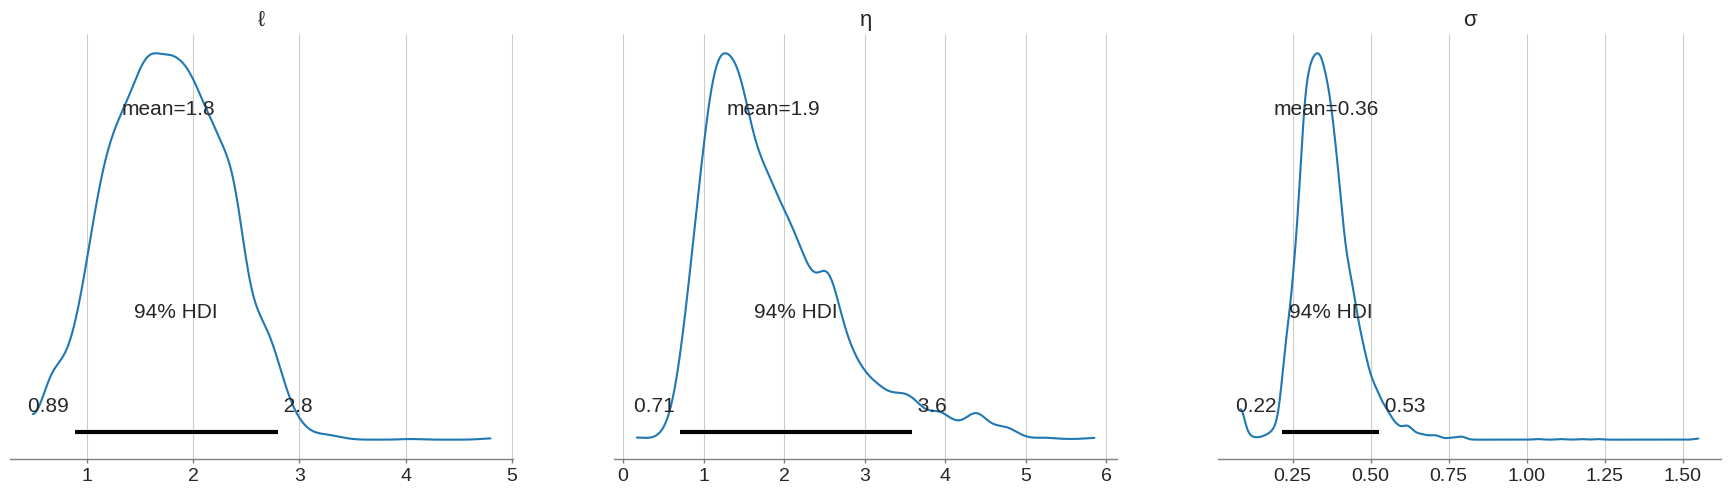

In [43]:
# 6. 결과 시각화
# --------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

# 사후 예측의 평균과 신뢰구간 계산
# pred_samples에서 f_pred의 샘플들을 가져옵니다.
predictions = pred_samples.posterior_predictive.stack(samples=("chain", "draw"))
mean_pred = predictions.mean(dim="samples") # 샘플들의 평균 -> 예측 평균 함수
# hdi_94 = az.hdi(posterior_predictive_samples, hdi_prob=0.94) # 94% 최고 밀도 구간(HDI)

# 원본 데이터 플로팅 (파란색 점)
ax.plot(X, y, 'o', color='tab:blue', label="Observed Data")

# GP 예측 평균 플로팅 (주황색 선)
ax.plot(Xnew, mean_pred['f_pred'].values, "-", color='red', label="Mean Prediction")

for i in range(len(predictions.samples)):
    y_pred = predictions['f_pred'].isel(samples=i)
    ax.plot(Xnew, y_pred, "-", color='tab:orange', alpha=0.05, zorder=-1)

# 실제 함수 플로팅 (회색 점선)
ax.plot(Xnew, true_func(Xnew), '--', color='gray', label='True Function')


ax.set_xlabel("X")
ax.set_ylabel("y")
ax.set_title("Gaussian Process Regression with PyMC")
ax.legend()
plt.show()

# 하이퍼파라미터의 사후 분포 시각화
az.plot_posterior(trace, var_names=["ℓ", "η", "σ"]);
plt.show()